In [1]:
import velvet as vt

# general packages
import numpy as np
import pandas as pd
import torch
from scipy.sparse import issparse

# velocity packages
import scanpy as sc
import scvelo as scv
import anndata as ann

# plotting packages
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from IPython.display import clear_output

# color palette object
from colors import colorpalette as colpal

Global seed set to 0
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
adata0 = vt.pp.read("../data/celltyped_adata.h5ad")
adata0 = adata0[adata0.obs.cell_annotation!='other']
adata0

View of AnnData object with n_obs × n_vars = 44713 × 24967
    obs: 'X_TC_alpha', 'total_TC_alpha', 'unspliced_TC_alpha', 'spliced_TC_alpha', 'p_e', 'p_c_TC', 'sample', 'timepoint', 'rep', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'label_rate', 'doublet_score', 'marker_based_classification', 'cell_annotation'
    layers: 'new', 'old', 'total'

In [3]:
neural_types = ['Early_Neural','Neural','FP','MN','pMN', 'V3', 'p3']
neural = adata0[[ct in neural_types for ct in adata0.obs.cell_annotation]]

neural_genes = vt.pp.select_genes(
    neural[neural.obs.rep!='r4'], 
    n_variable_genes=2000, 
    stratify_obs='rep')

In [4]:
neural = vt.pp.size_normalize(
    neural, 
    genes=neural_genes, 
    total_layer='total', 
    new_layer='new',
    unsparsify=True
)

vt.pp.neighborhood(neural, n_neighbors=100)

Using ScanPy methods to calculate distances, indices, connectivities, transitions, ... done! 
KNN indices for Velvet stored in .obsm['knn_index'].
Dense similarity transition matrix for Velvet stored in .obsm['Ts'].


In [5]:
neural = neural.copy()

vt.ut.set_seed(0)

vt.md.Velvet.setup_anndata(neural, x_layer='total', n_layer='new', knn_layer='knn_index', ts_layer='Ts')

model = vt.md.Velvet(
    neural,
    n_latent = 50,
    linear_decoder = True,
    neighborhood_space="latent_space",
    biophysical_model = "full",
    gamma_mode = "learned",
    labelling_time = 2.0,
)

model.setup_model()

model.train(
    batch_size = neural.shape[0],
    max_epochs = 1000, 
    freeze_vae_after_epochs = 200,
    constrain_vf_after_epochs = 200,
    lr=0.001,
)

INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


Multiprocessing is handled by SLURM.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1000/1000: 100%|██████████| 1000/1000 [06:24<00:00,  2.61it/s, loss=1.81, v_num=1]  

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [06:24<00:00,  2.60it/s, loss=1.81, v_num=1]


In [6]:
dynamic_gamma = model.module.loggamma.exp().detach().cpu().numpy()
ss_gamma = model.module.ss_gamma.detach().cpu().numpy()
shift = (dynamic_gamma - ss_gamma)

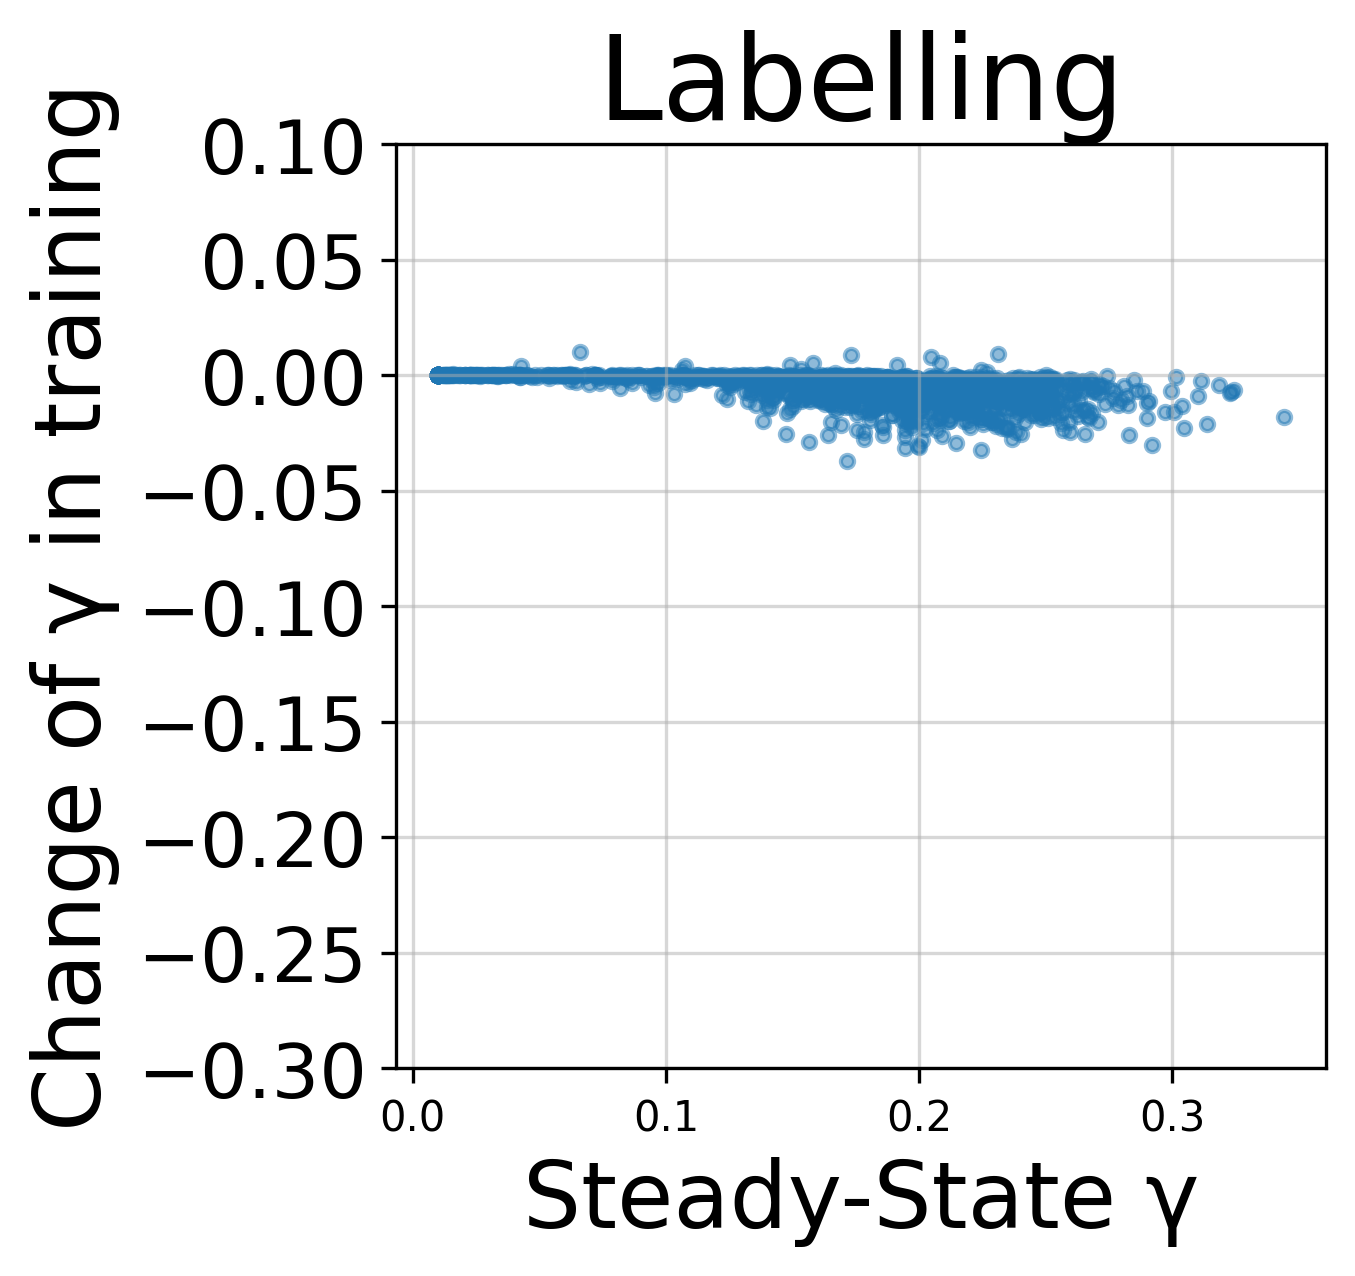

In [9]:
plt.figure(figsize=(4,4), dpi=300)
plt.scatter(ss_gamma, shift, s=10, alpha=.5, marker='o')
plt.xlabel('Steady-State γ', fontsize=22)
plt.ylabel('Change of γ in training', fontsize=22)
plt.grid(alpha=0.5)
plt.yticks(fontsize=18)
plt.ylim((-.3,.1))
plt.title("Labelling", fontsize=28)

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

# plt.savefig('../figures/2.4.0_gamma_labelling.png', bbox_inches='tight')
plt.show()

splicing

In [10]:
adata0 = vt.pp.read("../data/celltyped_adata_splicing.h5ad")
adata0 = adata0[adata0.obs.cell_annotation!='other']
adata0

View of AnnData object with n_obs × n_vars = 44713 × 24967
    obs: 'X_TC_alpha', 'total_TC_alpha', 'unspliced_TC_alpha', 'spliced_TC_alpha', 'p_e', 'p_c_TC', 'sample', 'timepoint', 'rep', 'marker_based_classification', 'cell_annotation'
    layers: 'spliced', 'unspliced'

In [11]:
neural_types = ['Early_Neural','Neural','FP','MN','pMN', 'V3', 'p3']
neural = adata0[[ct in neural_types for ct in adata0.obs.cell_annotation]]

neural_genes = vt.pp.select_genes(
    neural[neural.obs.rep!='r4'], 
    n_variable_genes=3000, 
    stratify_obs='rep')

neural = vt.pp.size_normalize_splicing(
    neural, 
    genes=neural_genes, 
    unsparsify=True
)

vt.pp.neighborhood(neural, n_neighbors=100)

neural = neural.copy()

vt.ut.set_seed(0)

vt.md.Svelvet.setup_anndata(neural, x_layer='total', u_layer='unspliced', knn_layer='knn_index', ts_layer='Ts')

model2 = vt.md.Svelvet(
    neural,
    n_latent = 50,
    linear_decoder = True,
    neighborhood_space="latent_space",
    gamma_mode = "learned",
)

model2.setup_model()

model2.train(
    batch_size = neural.shape[0],
    max_epochs = 1000, 
    freeze_vae_after_epochs = 200,
    constrain_vf_after_epochs = 200,
    lr=0.001,
)

Using ScanPy methods to calculate distances, indices, connectivities, transitions, ... done! 
KNN indices for Velvet stored in .obsm['knn_index'].
Dense similarity transition matrix for Velvet stored in .obsm['Ts'].
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


Multiprocessing is handled by SLURM.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1000/1000: 100%|██████████| 1000/1000 [08:14<00:00,  1.97it/s, loss=2.2, v_num=1]   

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [08:14<00:00,  2.02it/s, loss=2.2, v_num=1]


In [11]:
dynamic_gamma2 = model2.module.loggamma.exp().detach().cpu().numpy()
ss_gamma2 = model2.module.ss_gamma.detach().cpu().numpy()
shift2 = (dynamic_gamma2 - ss_gamma2)

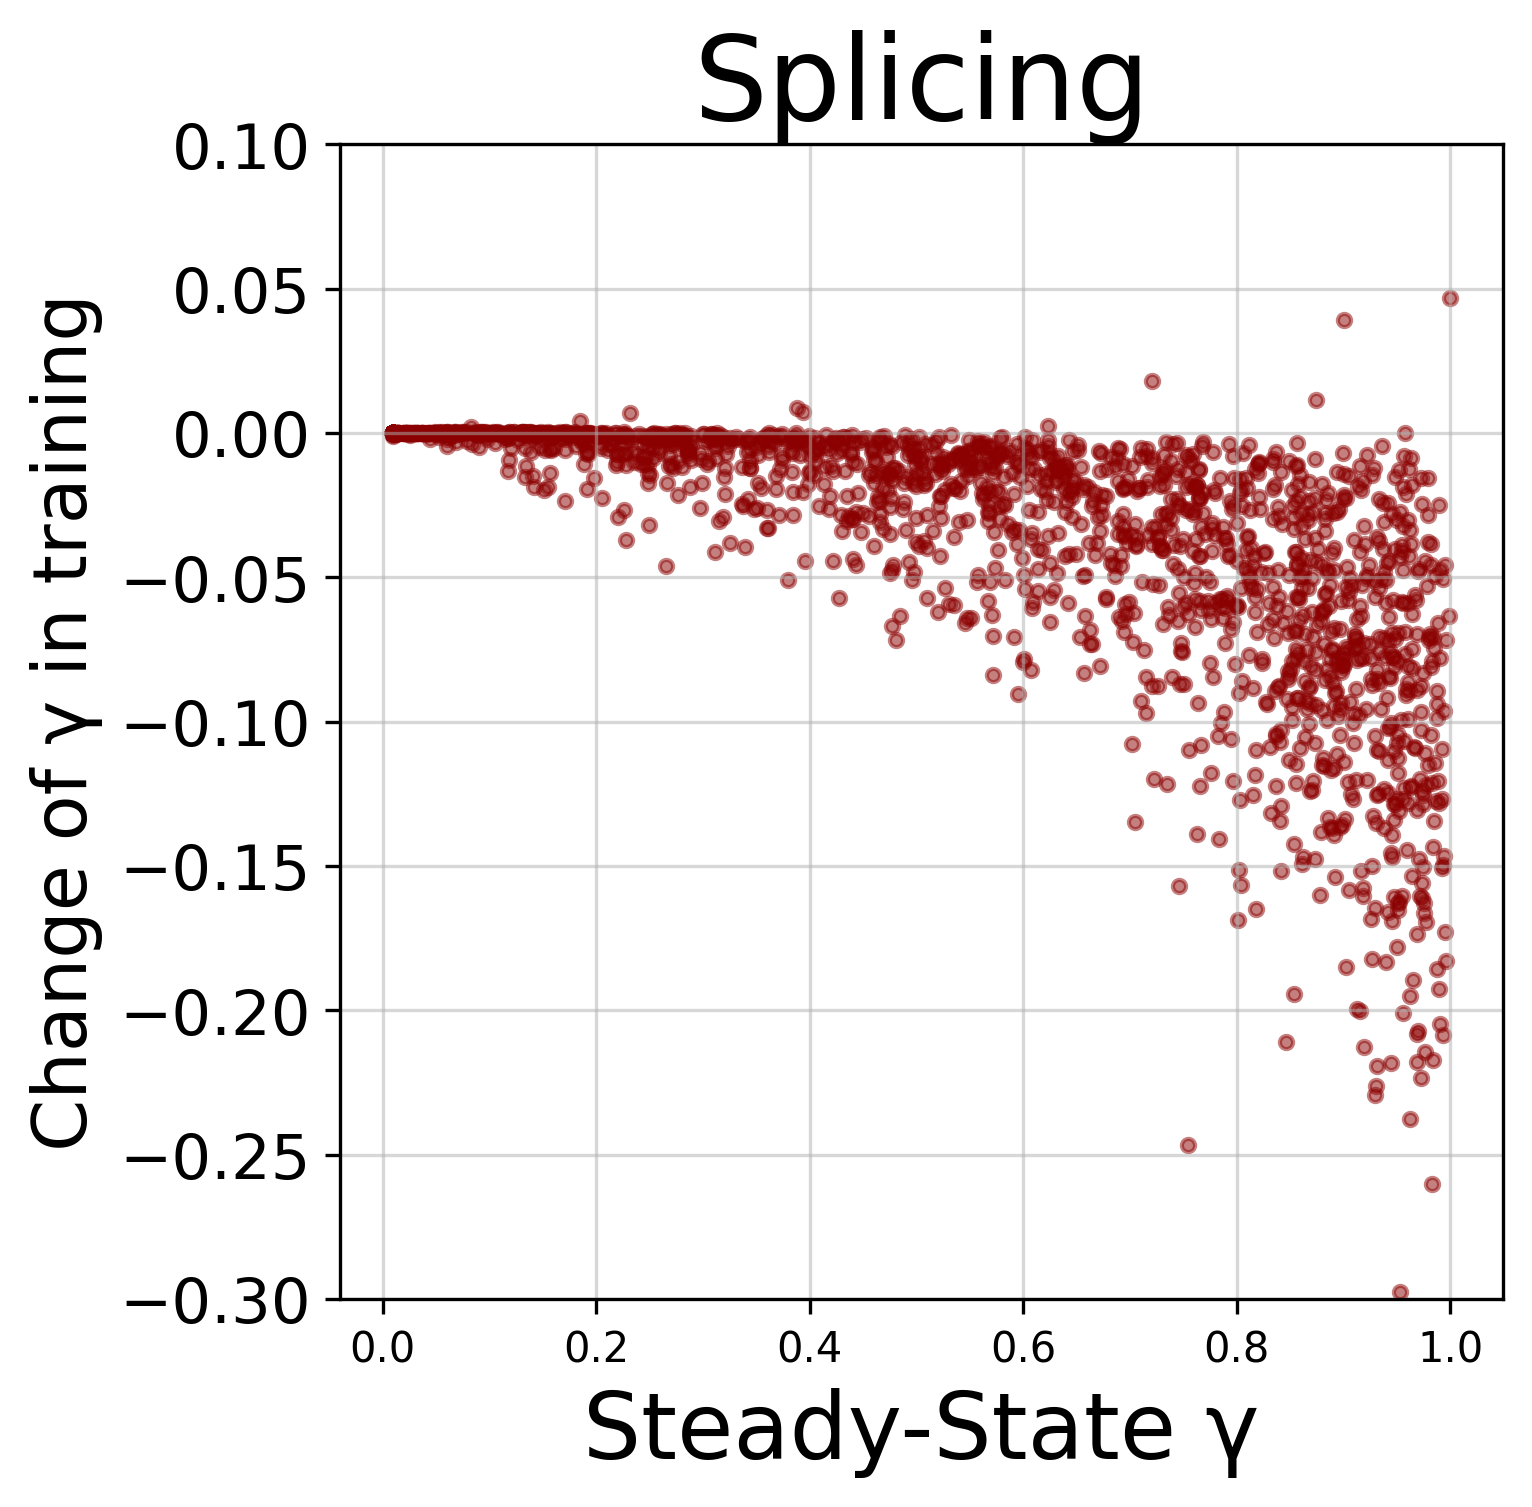

In [14]:
plt.figure(figsize=(5,5), dpi=300)
plt.scatter(ss_gamma2, shift2, s=10, alpha=.5, marker='o', color='darkred')
plt.xlabel('Steady-State γ', fontsize=22)
plt.ylabel('Change of γ in training', fontsize=18)
plt.grid(alpha=0.5)
plt.ylim((-.3,.1))
plt.yticks(fontsize=15)
plt.title("Splicing", fontsize=28)
for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

plt.savefig('../figures/2.4.1_gamma_splicing.png', bbox_inches='tight')
plt.show()

In [15]:
hl = pd.read_csv('../input_data/sharova_et_al_half_lives.csv')['Halflife for all cells'].values

hl= hl[hl>0.1]

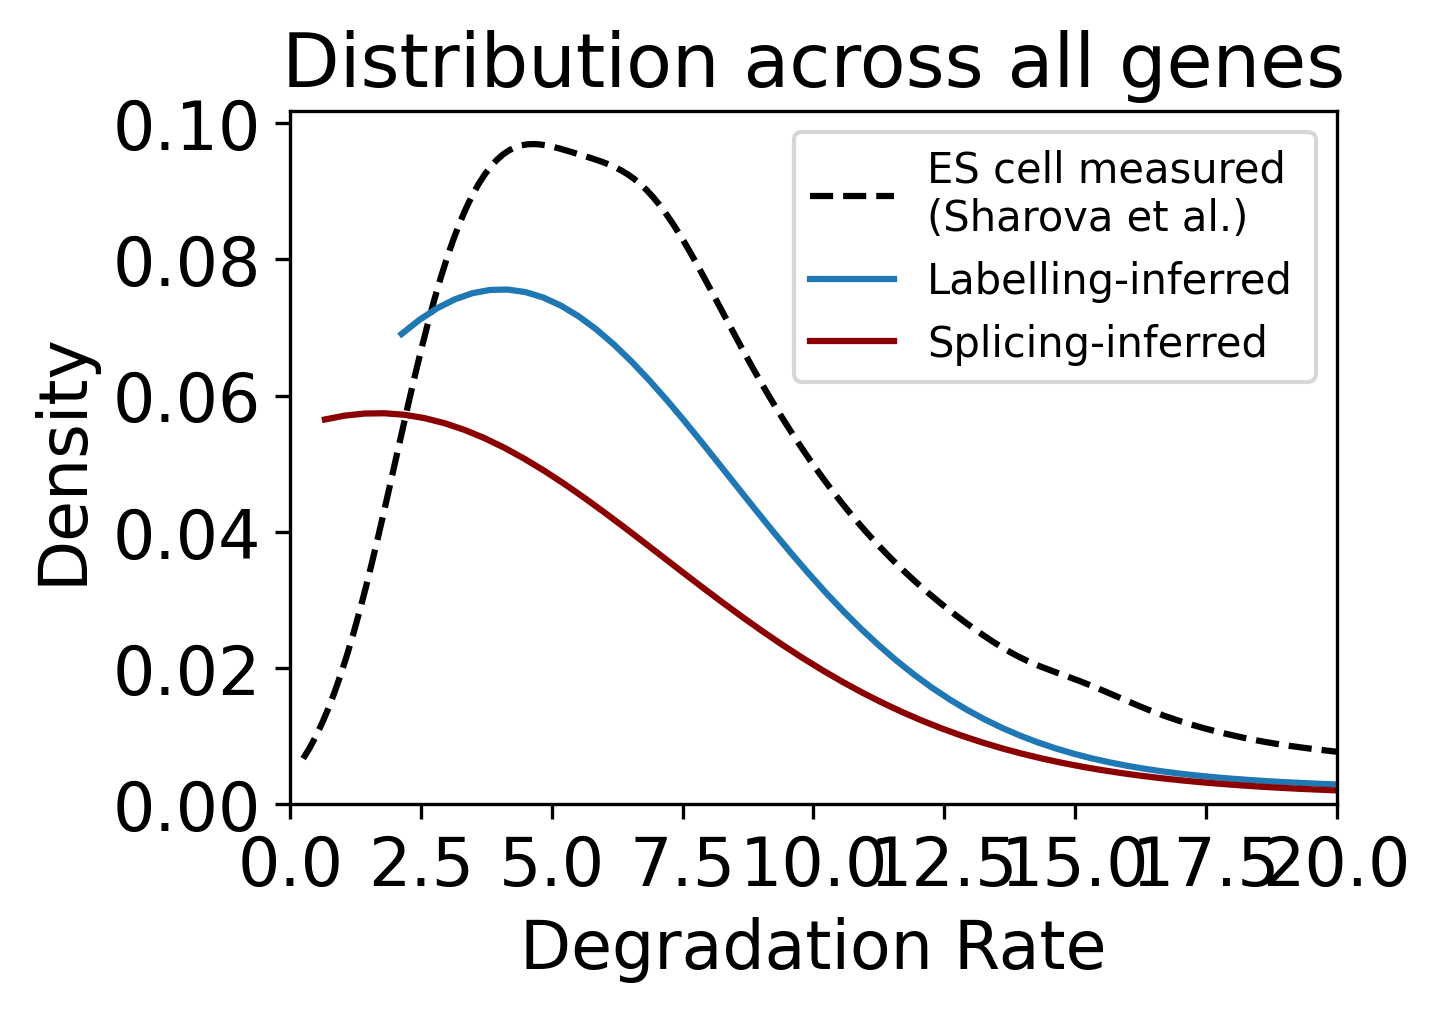

In [17]:
plt.figure(figsize=(4.5,3), dpi=300)
sns.kdeplot(hl, cut=0, label='ES cell measured \n(Sharova et al.)', color='k', linestyle='--')
sns.kdeplot(np.log(2) / dynamic_gamma, cut=0, label='Labelling-inferred', color='tab:blue')
sns.kdeplot(np.log(2) / dynamic_gamma2, cut=0, label='Splicing-inferred', color='darkred')
plt.xlim((0,20))
plt.legend()
plt.title("Distribution across all genes", fontsize=18)
plt.xlabel("Degradation Rate", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

plt.savefig('../figures/2.4.2_gamma_distributions.png', bbox_inches='tight')
plt.show()

In [17]:
hl = pd.read_csv('../input_data/sharova_et_al_half_lives.csv')
#['Halflife for all cells'].values

# hl = hl[hl>0.1]

In [20]:
hl['Gene symbol'].values

array(['Wdr74', 'D11Ertd497e', 'Tro', ..., 'Zfp273', 'A530032D15Rik',
       'Foxl2'], dtype=object)

In [26]:
shared = list(set(neural.var_names).intersection(hl['Gene symbol'].values))

In [34]:
shared[0]

'Scn9a'

In [42]:
xx = [hl[hl['Gene symbol']==sh]['Halflife for all cells'].mean() for sh in shared]

In [69]:
xx = np.array(xx)

In [53]:
yy1 = np.array([dynamic_gamma[np.where(neural.var_names==sh)[0][0]] for sh in shared])

In [55]:
yy = np.log(2) / yy1

<Axes: ylabel='Density'>

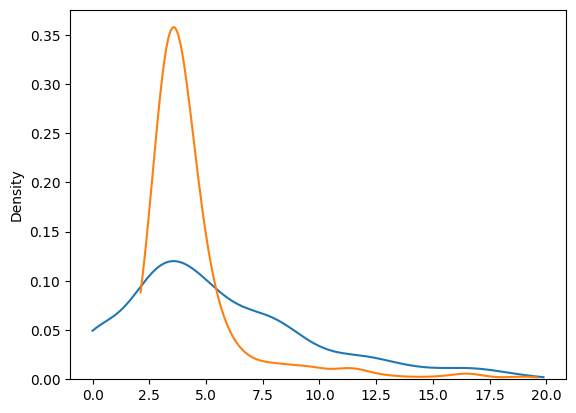

In [71]:
sns.kdeplot(xx[xx<20], cut=0)
sns.kdeplot(yy[yy<20], cut=0)
# plt.xlim((0,20))

(0.0, 10.0)

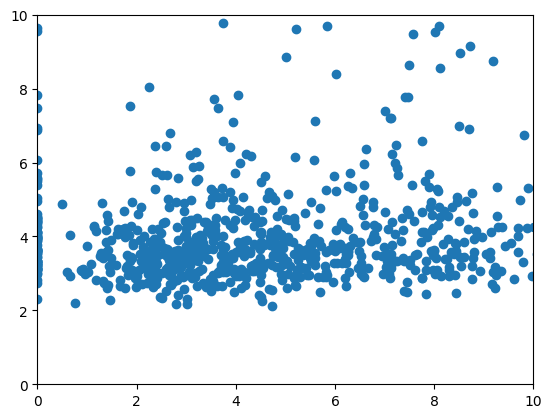

In [67]:
plt.scatter(xx,yy)
plt.xlim((0,10))
plt.ylim((0,10))